In [1]:
import scvi
import scanpy as sc
import numpy as np
from scvi.model import SCVI
from contrastive_vi.model.contrastive_vi import ContrastiveVIModel

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

Global seed set to 0
During startup - Warning messages:
1: package ‘methods’ was built under R version 3.6.1 
2: package ‘datasets’ was built under R version 3.6.1 
3: package ‘utils’ was built under R version 3.6.1 
4: package ‘grDevices’ was built under R version 3.6.1 
5: package ‘graphics’ was built under R version 3.6.1 
6: package ‘stats’ was built under R version 3.6.1 


In [2]:
from rich.console import Console

In [3]:
adata = sc.read_h5ad(
    "/projects/leelab/data/single-cell/zheng_2017/preprocessed/adata_top_2000_genes.h5ad"
)
adata.obs["integer_idx"] = np.arange(0, len(adata))
background_indices = adata[adata.obs["condition"] == "healthy"].obs["integer_idx"].tolist()
target_indices = adata[adata.obs["condition"] != "healthy"].obs["integer_idx"].tolist()

SCVI.setup_anndata(
    adata, layer="count"
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["count"]                                               
INFO     Successfully registered anndata object containing 16856 cells, 2000 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


### Train a contrastive-VI model

In [4]:
contrastive_vi_model = ContrastiveVIModel(
    adata,
    n_background_latent=10,
    n_salient_latent=5,
    use_observed_lib_size=False,
    dropout_rate=0.1,
)

INFO     contrastive_vi: The model has been initialized                                      


In [5]:
contrastive_vi_model.train(
    background_indices=background_indices,
    target_indices=target_indices,
    max_epochs=100,
    check_val_every_n_epoch=1,
    train_size=0.8,
    use_gpu="cuda:2",
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|██████████████████████████████████████████████████| 100/100 [06:16<00:00,  3.77s/it, loss=1.05e+05, v_num=1]


In [6]:
salient_latent = contrastive_vi_model.get_latent_representation(representation_kind="salient")
salient_latent = salient_latent[adata.obs["condition"] != "healthy"]
print(salient_latent.shape)

(12399, 5)


### Evaluate representations

In [7]:
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans

In [8]:
salient_adjusted_rand = adjusted_rand_score(
    adata.obs['condition'][adata.obs['condition'] != 'healthy'],
    KMeans(n_clusters=2).fit(salient_latent).labels_
)
salient_silhouette = silhouette_score(
    salient_latent, adata.obs['condition'][adata.obs['condition'] != 'healthy']
)

In [9]:
print(salient_adjusted_rand)
print(salient_silhouette)

0.7524991221272818
0.2197235


In [10]:
salient_latent_pca = PCA(n_components=2).fit_transform(salient_latent)

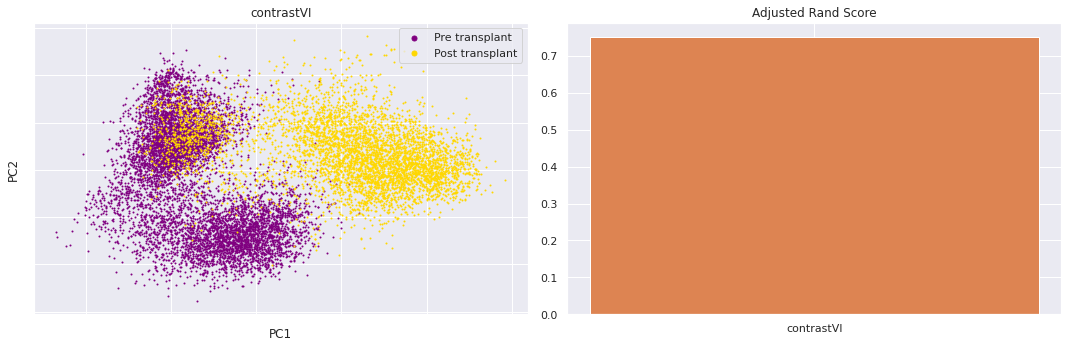

In [11]:
sns.set()

labels = adata.obs['condition'][adata.obs['condition'] != 'healthy']

fig, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

ax1.scatter(
    salient_latent_pca[:, 0][labels == 'pre_transplant'],
    salient_latent_pca[:, 1][labels == 'pre_transplant'], s=1, c='purple',
    label='Pre transplant'
)

ax1.scatter(
    salient_latent_pca[:, 0][labels == 'post_transplant'],
    salient_latent_pca[:, 1][labels == 'post_transplant'], s=1, c='gold',
    label='Post transplant'
)

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax1.legend(markerscale=5, loc='upper right')

ax1.set_title("contrastVI")

ax2.bar(['contrastVI'], [salient_adjusted_rand], color=[sns.color_palette()[1]])
ax2.set_title("Adjusted Rand Score")

plt.tight_layout()

In [12]:
from anndata import AnnData

In [13]:
obs = adata.obs[adata.obs["condition"] != "healthy"]
adata_salient_latent = AnnData(X=salient_latent, obs=obs)

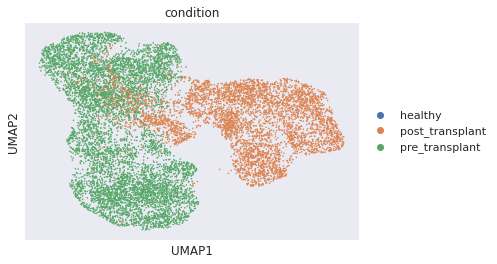

In [14]:
sc.pp.neighbors(adata_salient_latent)
sc.tl.umap(adata_salient_latent)
sc.pl.umap(adata_salient_latent, color="condition")